In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
#download the data

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [4]:
#quick look
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

#20639 total instances
#total_bedroom has 20433 instances 207 districts missing
#ocean_proximity is a categorical value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

#number of districts in each category


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

#summary

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
# code to save the figures as high-res PNGs

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

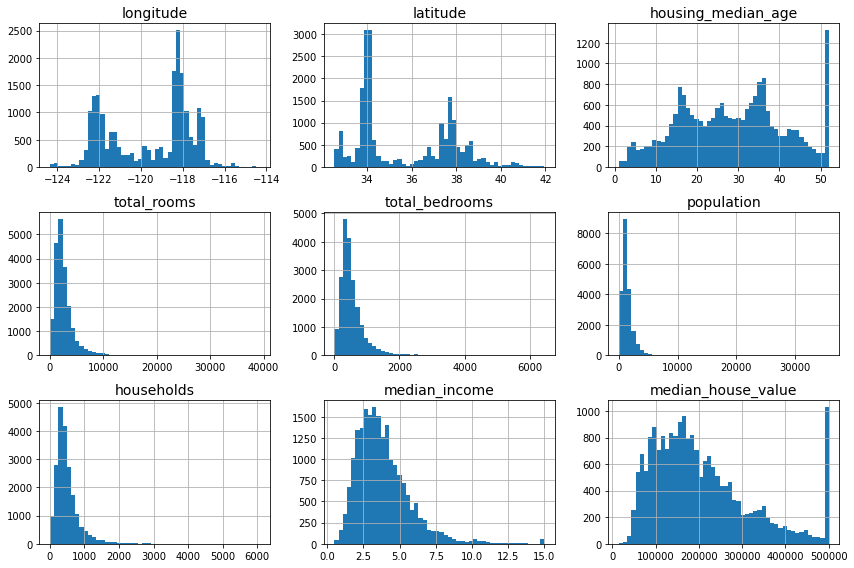

In [10]:
import matplotlib.pyplot as plt

# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots") 
plt.show()

# housing_median_age, median_house_value (target) has been scaled and capped 
# median_income data has been scaled and capped at 15 (higher median incomes) and at 0.5 (lower median incomes) numbers in tens of thousands of dollars (3 = $30,000)


In [11]:
#create a test set of about 20% of data and keep it aside

import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

In [14]:
#To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:
np.random.seed(42)

In [15]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#compute a hash of each instance's identifier and put that instance in the test set only if hash <= 20% of maximum hash value

In [16]:
housing_with_id = housing.reset_index()  # adds an `index` column. Use row index as ID
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [17]:
#used row index as a unique identifier, we should make sure that new data gets appended to end of dataset and mo row gets deleted
#can use an unique identifier like district's latitude and longitude

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [18]:
#scikit has inbuilt function to split data set

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
test_set["total_bedrooms"].isnull().sum()

44

In [20]:
# shows how to compute the 10.7% proba of getting a bad sample
#To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the binomial distribution. 
#The cdf() method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929946


In [22]:
#median income has continuous numeric values, so create categories for it
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

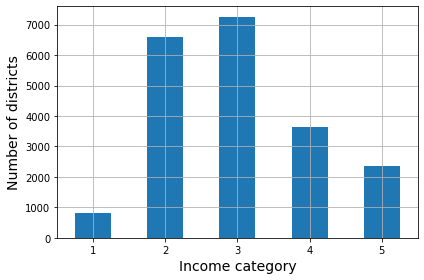

In [23]:
#represent these income categories through bar chart

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

In [24]:
#get a single stratified split using sklearn.model_selection package

from sklearn.model_selection import StratifiedShuffleSplit

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [25]:
#let's check if it works properly by looking at income category proportions in test set

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [26]:
#now let's check for full data set

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

#we can see stratified test set is almost similar to those in full datatset, 
#whereas test set generated using random sampliong is skewed

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [27]:
#we don't need income_cat anymore so drop it

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [28]:
#create a copy of training set to revert back as we are experimenting on full training set

housing = strat_train_set.copy()

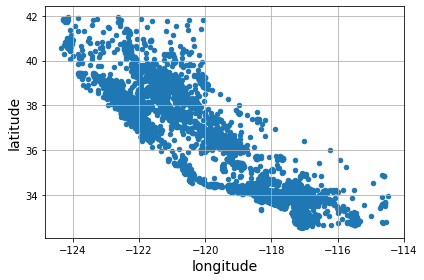

In [29]:
#visulaizing geographical data (latitude and longitude)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot") 
plt.show()

#difficult seeing any pattern, set an aplha value

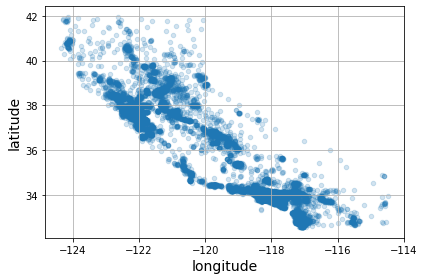

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

#can clearly see the high density areas

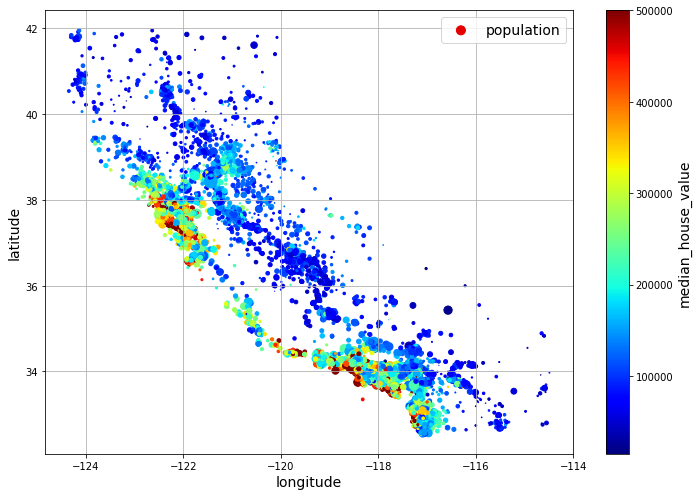

In [31]:
#now lets look at housing prices. Radius of each circle = distric's population (s), color = price(c). 
#Use predefined color map (cmap) called jet, ranging from blue(low prices) to red(high prices)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

#this plot shows housing prices are strongly related to location (e.g near ocean) and to population density
#clustering algorithm will be more useful for detecting main cluster and for adding new features that measures proximity to cluster centers
#ocean_proximity attribute can be useful as well.

In [32]:
#can compute standard correlation coefficient between every pair of attributes using corr() method

corr_matrix = housing.corr(numeric_only=True)

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

#median_income has highest correlation and longitude, latitude have lowest correlation

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

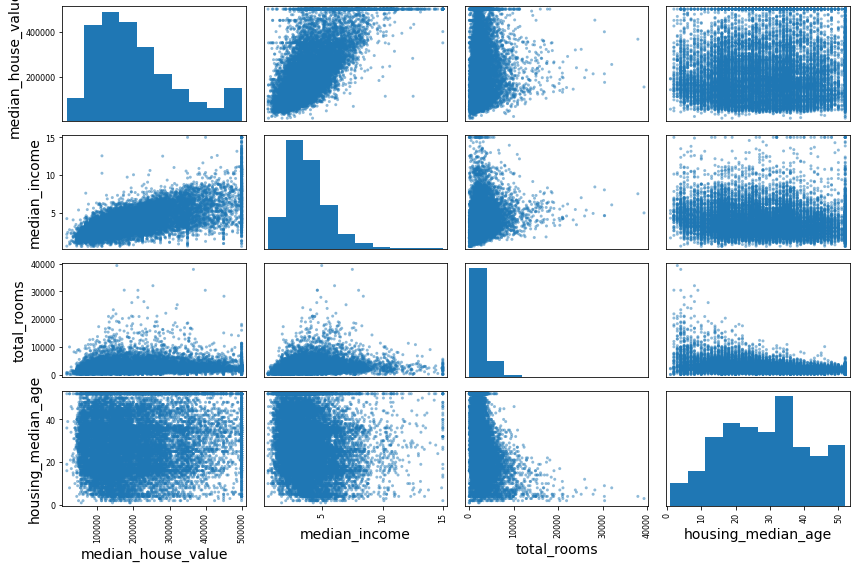

In [34]:
#another way to check correlation - use pandas scatter_matrix() function which plots every numerical attribute against every other numerical attribute

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

#pandas plot histogram when plotted each variable against itself
#can see median_income is most promising attribute

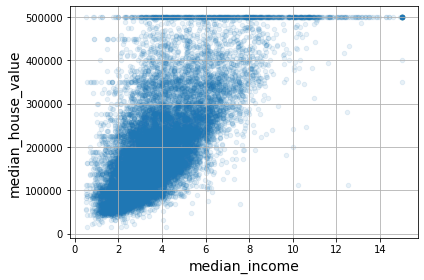

In [35]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

#strong correlation as upward trend and points not too dispersed
#price cap clearly visible as horizontal line at $500000
#few more horizontal lines seen.Try removing some corresponding districts tp prevent algorithm from learning to reproduce these data quirks

In [36]:
#experiment with attribute combinations

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [37]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

#can see rooms_per_house has strong correlation

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [97]:
#prepare data for machine learning algorithms
#write functions for this so that we can use it later for other datasets and projects

#first revert to clean training set by copying strat_train_set and separate predictors and labels since we dont want to apply same transformations to predictors and target values
#drop creates copy of data and does not affect strat_train_set

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [98]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [99]:
#Clean the data
#total_bedrooms has some missing values. You have 3 options:

housing.dropna(subset=["total_bedrooms"], inplace = True) #option1

housing.drop("total_bedrooms", axis = 1) #option2

median = housing["total_bedrooms"].median()  #option3
housing["total_bedrooms"].fillna(median, inplace = True)

In [100]:
#let's go with option 3


In [101]:
#use SimpleImputer from sklearn as it will store the median values of each feature - on training, validation, test sets and on any new data fed to the model

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [102]:
#Separating out the numerical attributes to use the "median" strategy (as it cannot be calculated on text attributes like ocean_proximity):

housing_num = housing.select_dtypes(include=[np.number])

In [103]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [104]:
#medians stored in statistics_ instance variable

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [105]:
#Check that this is the same as manually computing the median of each attribute:

housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [106]:
# now we can use this trained imputer to transform any missing values with medians

X = imputer.transform(housing_num)

In [107]:
X

#numpy array without column names and index
len(housing_num)

16344

In [108]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [109]:
#wrap X in DataFrame and recover column names and index

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [110]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [111]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [112]:
imputer.strategy

'median'

In [113]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [114]:
housing_tr.loc[null_rows_idx].head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [115]:
#from sklearn import set_config
#
# set_config(transform_output="pandas")  # scikit-learn >= 1.2

In [116]:
#drop some outliers

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [117]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [118]:
#If you wanted to drop outliers, you would run the following code:

#housing = housing.iloc[outlier_pred == 1]
#
#housing_labels = housing_labels.iloc[outlier_pred == 1]

In [119]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

#most ML algorithms prefer to work with numbers, so convert text to numbers
#for this use OrdinalEncoder class

len(housing_cat)


16344

In [120]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [121]:
housing_cat_encoded[:8]

,ocean_proximity
13096,3.0
14973,0.0
3785,1.0
14689,1.0
20507,4.0
1286,1.0
18078,0.0
4396,3.0


In [122]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [123]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [124]:
housing_cat_1hot

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


In [129]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [130]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [131]:
cat_encoder.transform(df_test)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0


In [132]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [133]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [134]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [135]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [136]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [138]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [140]:
#feature scaling
#Min-max scaling or normalization - values shifted and rescaled so they end up ranging from 0 to 1 or -1 to 1
#subtracting min value and dividing by (max-min)

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [141]:
#Standard Scalar - values not concised to range. But is less affected by outliers
#subtracts mean value and divides result by standard deviation

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

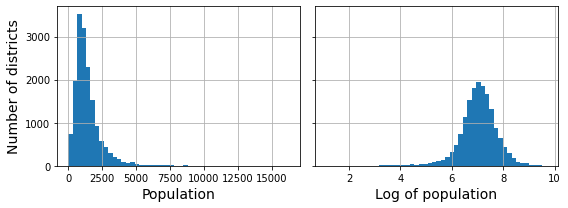

In [142]:
#when feature has heavy or long tail (values far from mean are not exponentially rare), both min-max and standardization scaling will squash most values to small range
#so to get symmetrical distribution use log of the attribute which has heavy tail, here use log of "population" attribute

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

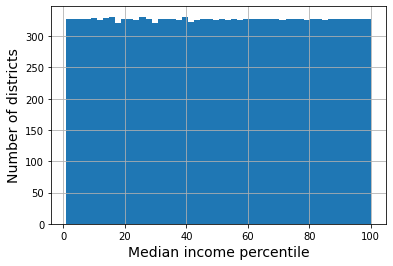

In [143]:
#another method - bucketizing - convert distribution into equal sized buckets and replace each feature with index of bucket
#for example, replace each value with its percentile

percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

In [223]:
#multimodal distribution (has 2 or more peaks called modes) such as housing_median_age feature
#to transform this add new feature for each of the modes (atleast main ones) representing similarity between hosuing median age and that particular mode
#use radial basis function (RBF) like gaussian rbf whose output value decays exponentially as input value moves away
#rbf - distance between input value and fixed point
#here gaussian rbf measures similarity between housing median age and 35

from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

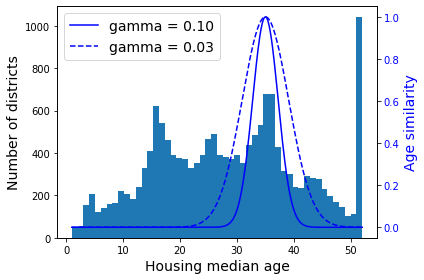

In [224]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [263]:
len(housing)

16512

In [264]:
#target values also need to be transformed and if we use log to transform target value it will predict log of the target value instead of target value
#use inverse_transform() for this 
#now scale labels using StandardScaler, then train simple regression model on scaled labels and use it to make predictions on new data
#this is then transformed back to the original scale using inverse_transform()

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [227]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [228]:
#easier to use TransformedTargetRegressor and pass the original unscaled labels. It automatically scales the labels and train the regression model based on these scaled labels

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [229]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [230]:
#Custom transformation
#let's create a log-transformer and apply yo the population feature as before

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) #inverse_func is optional. It lets you specify an inverse transform function if you plan to use it in TransformedTargetRegressor
log_pop = log_transformer.transform(housing[["population"]])

In [231]:
#transformation function can take hyperparameters as additional arguments
#let's create a transformer that computes the same Gaussian RBF similarity measure as earlier

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [232]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [233]:
#rbf_kernel() doesn not treat features separately. If we pass it an array with 2 features, it will measure the 2D distance (Euclidean) to measure similarity
#Let's add a feature that will measure geographic similarity between each district and San Francisco

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [234]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [235]:
#custom transformers are also useful in combining features
#FunctionTransformer that computes ratio between input features 0 and 1

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [236]:
#if we want our transformer to be trainable - learning some parameters in fit() method and use them in transform() method
#we need to create a class for this

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [237]:
#A custom transformer often use other estimators in its implementation
#Here we use a KMeans clusterers in fit() method to identify main clusters in training data
#and then uses rbf_kernel() in transform() method to measure how similar each sample is to cluster center

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [238]:
#let's use this transformer in our data

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

#Creates ClusterSimilarity transformer, number of clusters = 10
#fit_transform() with latitude and longitude of every district in training set and sample_weight = median house value
#uses k-means to locate clusters, then measures Gaussian RBF similarity between each district and all 10 cluster centers
#result is one row per district, one column per cluster

In [239]:
similarities[:3].round(2)

,Cluster 0 similarity,Cluster 1 similarity,Cluster 2 similarity,Cluster 3 similarity,Cluster 4 similarity,Cluster 5 similarity,Cluster 6 similarity,Cluster 7 similarity,Cluster 8 similarity,Cluster 9 similarity
13096,0.08,0.00,0.6,0.00,0.0,0.99,0.00,0.00,0.00,0.14
14973,0.00,0.99,0.0,0.04,0.0,0.00,0.11,0.00,0.63,0.00
3785,0.44,0.00,0.3,0.00,0.0,0.70,0.00,0.01,0.00,0.29


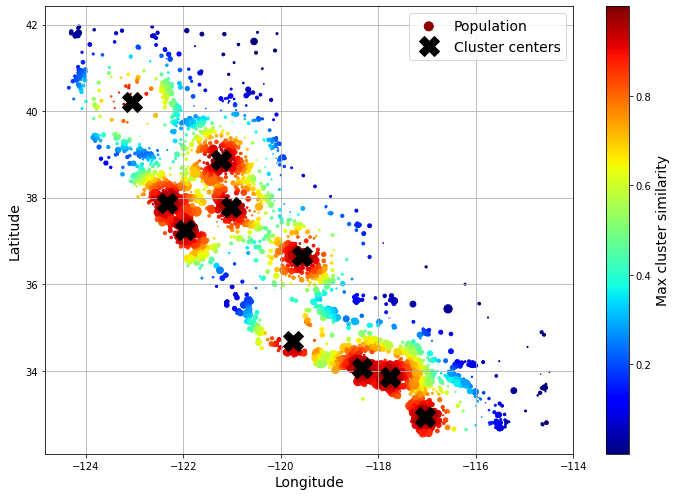

In [240]:
#let's visualize this

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [241]:
#Transformation Pipelines
#Let's create a simple numerical pipeline

from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [242]:
#make_pipeline function takes transformers as positional arguments and creates a pipeline using names of transformers' classes

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [243]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [244]:
#pipeline exposes same methods as final estimator. here it is StandardScaler() which is a transformer
#if we call pipeline's transform() method, it will sequentially apply all transformations to the data
#if last estimator was predictor it would have a predict() method rather than transform()

#let's call pipeline's fit_transform() method

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.42,1.01,1.86,0.31,1.36,0.14,1.40,-0.94
14973,0.60,-0.70,0.91,-0.31,-0.44,-0.69,-0.37,1.17


In [245]:
def monkey_patch_get_signature_names_out():
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [246]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [247]:
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.422634,1.013124,1.860687,0.310661,1.359094,0.137572,1.395732,-0.937557
14973,0.596681,-0.702274,0.907526,-0.308789,-0.436356,-0.693276,-0.373537,1.171380


In [248]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [249]:
num_pipeline[1]

StandardScaler()

In [250]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [251]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [252]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [253]:
#so far we handled categorical and numerical attributes separately
#let's create a single transformer - column transformer - which can handle both and all columns
#it will apply num_pipeline we created for numerical attributes and cat_pipeline for categorical attributes

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output = False))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [254]:
#use make_column_selector to create num as well as categorical pipeline together

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [255]:
housing_prepared = preprocessing.fit_transform(housing)

In [256]:
#shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-1__median_house_value,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,2.185112,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,2.406254,1.0,0.0,0.0,0.0,0.0


In [257]:
#make a pipleine consisting of following things
#missing values in numerical features will be replaced by median as most ML algorithms dont expect missing values
#categorical features will be one-hot encoded as ML models expect only num inputs
#few features will be computed and added - bedrooms_ratio, rooms_per_house, people_per_house. See if they better correlate with housing_median_value
#cluster similarity features for latitudes and longitudes will be added
#features with long tail replaced by their logarithms as most ML models expect symmetrical distribution like Gaussian
#all num features will be standardized


In [258]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape


(16512, 25)

In [259]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__median_house_value'],
      dtype=object)

In [260]:
#Let's train a basic linear regression model to get started

from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fc...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcd61944880>)])),
                ('linearregression', LinearRegression())])

In [261]:
#look at first five predictions

housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([458300., 483800., 101700.,  96100., 361800.])

In [262]:
#Compare against the actual values:

housing_labels.iloc[:5].values

#very accurate


array([458300., 483800., 101700.,  96100., 361800.])

In [213]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

0.0%, 0.0%, 0.0%, 0.0%, 0.0%


In [214]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

#very minimum error almost close to zero

1.8002816974950336e-10

In [267]:
pd.Series(lin_rmse).describe()

count    1.000000e+00
mean     1.800282e-10
std               NaN
min      1.800282e-10
25%      1.800282e-10
50%      1.800282e-10
75%      1.800282e-10
max      1.800282e-10
dtype: float64

In [215]:
#Let's try decisontreeregressor

from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fc...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcd6369f040>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [216]:
#let's try DecisionTrees, a poewerful model

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

#zero error! but chances are model has badly overfit the data

0.0

In [265]:
#Better Evaluation using cross validation
#this code uses k-fold cross-validation feature. It solits traininfg set into 10 nonoverlapping subsets called folds
#then it trains and evaluates decision tree model 10 times, picking different fold for evaluation every time and use other 9 folds for training
#result is an array containing 10 evaluation scores

from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [266]:
pd.Series(tree_rmses).describe()

count     10.000000
mean     145.565600
std       45.806952
min       87.055686
25%      117.133026
50%      137.755118
75%      160.933035
max      219.388778
dtype: float64

In [268]:
# computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    1.000000e+01
mean     1.343367e-10
std      4.224484e-11
min      8.225653e-11
25%      1.036624e-10
50%      1.200889e-10
75%      1.682086e-10
max      2.011695e-10
dtype: float64

In [269]:
#Lets try randomforestregressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [270]:
pd.Series(forest_rmses).describe()

count    10.000000
mean     70.484883
std      16.871031
min      45.472958
25%      60.367949
50%      72.065886
75%      76.356833
max      96.389059
dtype: float64

In [222]:
#Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

25.98392523937531

In [271]:
#Fine tune your model using GridSearchCV
#Tell it which hyperparameters you want to experiment it with and what values to try out
#it will use cross-validation to evaluate all possible combinations

#Let's try it for RandomForestRegressor

from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5,8,10], #splits this string at double underscores and looks for an estimator named 'preprocessing' in ColumnTransformer
     #then it looks for transformer 'geo' inside ColumnTransformer and finds ClusterSimilarity transformer we used on latitudes and longitudes
    'random_forest__max_features': [4,6,8]},
    {'preprocessing__geo__n_clusters': [10,15],
    'random_forest__max_features': [6,8,10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(housing,housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcd61944880>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [272]:
# shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'prepr

In [273]:
#The best hyperparameter combination found:
grid_search.best_params_

#n_clusters = 5 and max_features = 8

{'preprocessing__geo__n_clusters': 5, 'random_forest__max_features': 8}

In [274]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fcd7b5...
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcd61937580>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=8, random_state=42))])

In [276]:
#Evaluation scores are available using grid_search.cv_results. Output is dictionary but can wrap it in dataframe
#Let's look at the score of each hyperparameter combination tested during the grid search:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
2,5,8,3566,2694,3266,3175
11,10,10,3846,3417,3638,3634
5,8,8,5104,4496,4885,4828
14,15,10,5661,4633,5615,5303
8,10,8,6021,5456,5896,5791


In [277]:
#Randomized search is more preferable because:
#It will explore 1000 different values if we set it to 1000 iteratiins, grid search only explores few values
#if hyperparameters has 10 values, grid search will take 10 times longer. In random search it doesnt make difference

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [278]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcd75ea6d60>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcd7c7fb100>},
                   random_state=42, scoring='neg_root_mean_squared_error')

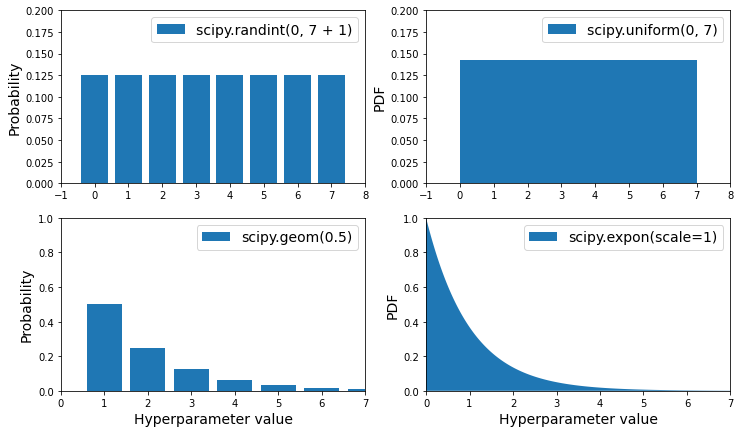

In [279]:
# plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

In [323]:
#Let's inspect best model to indicate importance of each attribute
final_model = rnd_search.best_estimator_  
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.02, 0.02, 0.02, 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.  ,
       0.  , 0.  , 0.66])

In [324]:
#sort these importance scores in descending order and display them with their attributes

sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.6633371273122155, 'remainder__median_house_value'),
 (0.14111429527576663, 'log__median_income'),
 (0.06283130691323202, 'cat__ocean_proximity_INLAND'),
 (0.024093276252829345, 'bedrooms__ratio'),
 (0.021022870059821317, 'rooms_per_house__ratio'),
 (0.01839182191664626, 'people_per_house__ratio'),
 (0.0071083151742158904, 'geo__Cluster 2 similarity'),
 (0.006650987406313734, 'geo__Cluster 16 similarity'),
 (0.004656015987862031, 'cat__ocean_proximity_<1H OCEAN'),
 (0.004281807919975006, 'geo__Cluster 0 similarity'),
 (0.004148119467113875, 'geo__Cluster 12 similarity'),
 (0.004132315923790057, 'geo__Cluster 1 similarity'),
 (0.0035477892850218993, 'geo__Cluster 5 similarity'),
 (0.0032647984366064647, 'geo__Cluster 7 similarity'),
 (0.0031373233150197035, 'remainder__housing_median_age'),
 (0.0027550536739363025, 'geo__Cluster 8 similarity'),
 (0.0025267691690389273, 'geo__Cluster 13 similarity'),
 (0.0025112576623238657, 'geo__Cluster 17 similarity'),
 (0.0023998219968786416, 'geo

In [354]:
#Evaluate Your System on the Test Set
strat_test_set.shape


(4128, 10)

In [355]:
strat_train_set.shape

(16512, 10)

In [370]:
X_test = strat_test_set
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

4566.059771761048


In [371]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([4049.62685693, 5029.74412851])

In [372]:
print(strat_test_set.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.95     37.11                21.0       2387.0           357.0   
1    -118.01     33.89                36.0       1589.0           265.0   
2    -118.18     33.74                30.0       5915.0          1750.0   
3    -122.48     37.74                52.0       2166.0           423.0   
4    -122.39     37.78                 5.0       1405.0           515.0   

   population  households  median_income  median_house_value ocean_proximity  
0       913.0       341.0         7.7360            397700.0       <1H OCEAN  
1       804.0       272.0         4.6354            202900.0       <1H OCEAN  
2      2136.0      1503.0         4.0968            310000.0      NEAR OCEAN  
3      1072.0       370.0         4.1310            314300.0      NEAR OCEAN  
4       725.0       392.0         3.6037            187500.0        NEAR BAY  
